### HW 5 Animal faces classification

Kaggle url: https://www.kaggle.com/datasets/andrewmvd/animal-faces

In [58]:
import torch
import torch.nn as nn
import numpy as np
from torchvision import datasets, transforms

# metric
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

Connecting CUDA

In [59]:
device = torch.device('cuda')

In [63]:
torch.cuda.is_available()

True

Train function

In [64]:
from tqdm import tqdm # to show progress bar

In [65]:
def train(net, n_epoch=2):
    # choosing loss function
    loss_fn = torch.nn.CrossEntropyLoss()

    # choosing optimization algoritm and learning_rate
    learning_rate = 1e-3
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

    # test accuracy
    best_accuracy = 0
    # training net for 2 epochs
    for epoch in tqdm(range(n_epoch)):
    
        running_loss = 0.0
        train_dataiter = iter(train_loader)
        for i, batch in enumerate(tqdm(train_dataiter)):
            # getting a batch
            X_batch, y_batch = batch
            # passing a batch to a vram
            # if not sure that device = gpu you can write .cuda()
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            # zeroing weights
            optimizer.zero_grad()

            # forward pass (getting answers to a batch of pictures)
            y_pred = net(X_batch)
            # calculating loss for answers and true answers of a batch
            loss = loss_fn(y_pred, y_batch)
            # backpropagation (calculating gradients)
            loss.backward()
            # updating weithts
            optimizer.step()

            # checking accuracy every 1500 batches (~half epoch)
            if i % 1500 ==0:
                # context manager of torch points to not updating parameters
                with torch.no_grad():
                    accuracy = []
                    for batch in test_loader:
                        x, y = batch
                        # passing to gpu
                        x = x.to(device)
                        y = y.to(device)
                        # predicting
                        y_pred = net(x)
                        # loss = loss_fn(y_pred, y)
                        # finding test batch accuracy
                        accuracy.append(accuracy_score(y.detach().cpu().numpy(), np.argmax(y_pred.detach().cpu().numpy(), axis=1)))
                    # calculating mean accuracy of all batches on test
                    accuracy = np.mean(np.array(accuracy))
                    # if become better - save on disk and update best metric
                    if accuracy > best_accuracy:
                        print('New best model with test acc:', accuracy)
                        torch.save(net.state_dict(), './best_model.pt')
                        best_accuracy = accuracy

            # showing current loss
            running_loss += loss.item()
            # showing quality every 500 batches
            if i % 500 == 499:
                print('[%d, %5d] loss: %.3f' %
                        (epoch + 1, i + 1, running_loss / 500))
                running_loss = 0.0

    print('Training complete')
    return net

Transforming, augmenting, normalizing

In [66]:
# out of the box we can resize all pictures , convert to tensor , augment and normalize
transform_train = transforms.Compose([
         transforms.Resize((224, 224)),
         transforms.AutoAugment(),
         transforms.ToTensor(),
         transforms.Normalize(mean=[0.485, 0.456, 0.406],  # mean and std of entire dataset (usually imagenet), on which a net was trained
                              std=[0.229, 0.224, 0.225]),
])
# отдельный для теста
transform_val = transforms.Compose([
         transforms.Resize((224, 224)),                           
         transforms.ToTensor(),
         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225]),
])

In [67]:
# while loading , also transforming
train_data = datasets.ImageFolder("train", transform=transform_train)
test_data = datasets.ImageFolder("val", transform=transform_val)
# also in transforms since version 1.8+ there is augmentation

In [68]:
train_data

Dataset ImageFolder
    Number of datapoints: 14630
    Root location: train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               AutoAugment(policy=AutoAugmentPolicy.IMAGENET, fill=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

Dividing by batches

In [109]:
# dividing by batches (usually taking maximum that can be passed to vram)
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=512, 
    shuffle = True, 
    pin_memory=True, 
    num_workers=6
    )
test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=512, 
    shuffle = True, 
    pin_memory=True, 
    num_workers=6
    )

In [110]:
dataiter = iter(train_loader)
# picture batch and label batch
images, labels = next(dataiter)

In [111]:
# pictire sizes
images.shape, labels.shape

(torch.Size([512, 3, 224, 224]), torch.Size([512]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(2)


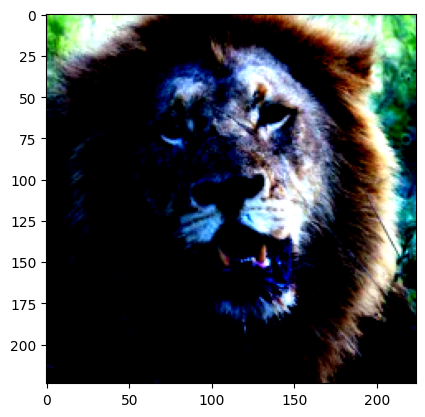

In [171]:
pn = 1
plt.imshow(np.squeeze(np.transpose(images[pn].numpy(), (1, 2, 0))))
print(labels[pn])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

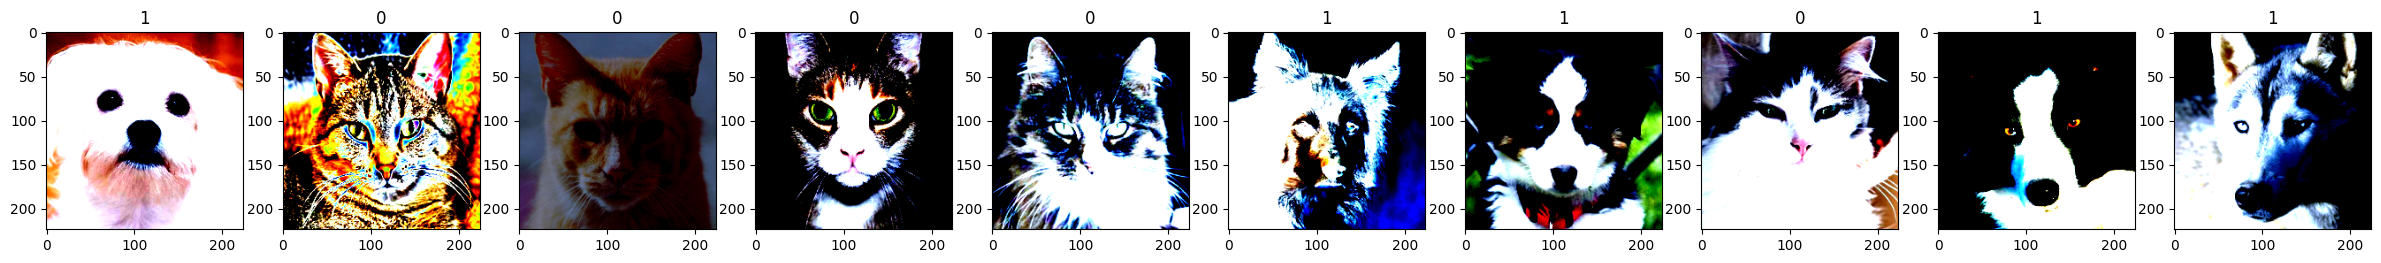

In [113]:
# showing images after transformations
def show_imgs(imgs, labels):
    f, axes= plt.subplots(1, 10, figsize=(30,5))
    for i, axis in enumerate(axes):
      axes[i].imshow(np.squeeze(np.transpose(imgs[i].numpy(), (1, 2, 0))))
      axes[i].set_title(labels[i].numpy())
    plt.show()

show_imgs(images, labels)

Finetuning

In [114]:
# module where layers of nn are defined
import torch.nn as nn
# module where activations of nn are defined
import torch.nn.functional as F

In [115]:
from torchvision import models

In [117]:
# we will take a pretrained model VGG16
vgg16 = models.vgg16(weights=True)

C:\Users\beori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [118]:
vgg16.parameters

<bound method Module.parameters of VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size

In [119]:
# we dont need last layer, deleting it
vgg16.classifier = nn.Sequential(*list(vgg16.classifier.children()))[:-1]

In [120]:
vgg16.parameters

<bound method Module.parameters of VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size

In [121]:
class New_VGG16(nn.Module):
    def __init__(self):
        super().__init__()
        self.vgg16 = vgg16 # entire net in one string of a code
        for param in self.vgg16.features.parameters(): # turning off parameter updating
            param.requires_grad = False
        self.fc = nn.Linear(4096, 3) # adding new layer
    
    def forward(self, x):
        # forward pass of a net
        # multiplying by a weight matrix of a 1 layer and applying activation function
        x = self.vgg16(x)
        x = self.fc(x)
        return x

In [122]:
torch.cuda.empty_cache()
import gc
gc.collect()

55691

In [123]:
net = New_VGG16().to(device)
train(net)

  0%|          | 0/2 [00:00<?, ?it/s]

New best model with test acc: 0.9541918329831933


 50%|█████     | 1/2 [00:33<00:33, 33.74s/it]

New best model with test acc: 0.9938944327731093


100%|██████████| 2/2 [01:07<00:00, 33.85s/it]

Обучение закончено


New_VGG16(
  (vgg16): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16)

In [124]:
test_dataiter = iter(test_loader)
images, labels = next(test_dataiter)

Taking labels from test dataset and the net

In [125]:
labels_net = []
labels_true = []
for images, labels in test_loader:
    labels_true.extend(labels)
    labels_net.extend(net.forward(images.cuda()).detach().cpu().numpy())

Metrics on test data

In [166]:
from sklearn.metrics import classification_report

In [175]:
print(classification_report(labels_true, np.argmax(np.array(labels_net), axis=1),digits = 3,target_names=['Cats','Dogs','Wild life']))

              precision    recall  f1-score   support

        Cats      1.000     0.998     0.999       500
        Dogs      0.998     1.000     0.999       500
   Wild life      0.998     0.998     0.998       500

    accuracy                          0.999      1500
   macro avg      0.999     0.999     0.999      1500
weighted avg      0.999     0.999     0.999      1500



In [168]:
accuracy_score(labels_true, np.argmax(np.array(labels_net), axis=1))

0.9986666666666667

Saving weights of the net

In [130]:
torch.save(net.state_dict(),'best_model')

Individual pictures

In [152]:
from PIL import Image

In [147]:
transform = transforms.Compose([
         transforms.Resize((224, 224)),
         transforms.AutoAugment(),
         transforms.ToTensor(),
         transforms.Normalize(mean=[0.485, 0.456, 0.406], # mean and std of entire dataset (usually imagenet), on which a net was trained
                              std=[0.229, 0.224, 0.225]),
])

In [180]:
img = Image.open("manul.jpg")
img.show()

img_t = transform(img)

batch_t = torch.unsqueeze(img_t,0)

out = np.argmax(net.forward(batch_t.cuda()).detach().cpu().numpy(), axis=1)

print('Net assumption: it is a',end=' ')
if out[0] == 0:
    print('Cat')
elif out[0] == 1:
    print('Dog')
else:
    print('Wild life creature')

Net assumption: it is a Wild life creature
